In [3]:
import imageio
import ffmpeg
import av

import numpy as np

import sys
from glob import glob


import site
site.addsitedir('../../ARGUS')
from ARGUSUtils import *

In [4]:
data_paths = sorted(glob("../../Data/TestingData/BAMC-PTX*Sliding/*.m??"))

In [5]:
def shape_ffmpeg( filename ):
    p = ffmpeg.probe(filename, select_streams='v');
    width = p['streams'][0]['width']
    height = p['streams'][0]['height']
    return height, width

def load_ffmpeg( filename, height, width ):
    p = ffmpeg.probe(filename, select_streams='v');
    width = p['streams'][0]['width']
    height = p['streams'][0]['height']

    in_bytes, _ = (
        ffmpeg
        .input(filename)
        .video # Video only (no audio).
        .output('pipe:', format='rawvideo', pix_fmt='gray')  # Set the output format to raw video in 8 bit grayscale
        .run(capture_stdout=True)
    )
    n_frames = len(in_bytes) // (height*width)  # Compute the number of frames.
    frames = np.frombuffer(in_bytes, np.uint8).reshape(n_frames, height, width) # Reshape buffer to array of n_frames frames (shape of each frame is (height, width)).
    return frames

In [6]:
def load_imageio( filename, height, width ):
    vid = imageio.get_reader(filename, 'ffmpeg')
    num_frame = vid.count_frames()
    img = np.empty((num_frame,height,width))
    count = 0
    for f in range(num_frame):
        img[count] = np.squeeze(np.mean(vid.get_data(f),axis=2))
        count += 1
    return img

In [11]:
def load_av( filename, height, width ):
    container = av.open(filename)
    stream = container.streams.video[0]
    stream.thread_type = 'AUTO'
    
    num_frames = stream.frames

    frames = np.empty((num_frames,height,width))
    for i,frame in enumerate(container.decode(stream)):
        frames[i] = frame.to_ndarray(format='gray')
        
    #for i in range(num_frames):
        #frames[i] = im[i]
    return frames

In [12]:
height,width = shape_ffmpeg(data_paths[0])
num_vid = 1 #len(data_paths)

with time_this('load_ffmpeg'):
    for i in range(num_vid):
        imgF = load_ffmpeg(data_paths[i],height,width)

with time_this('load_imageio'):
    for i in range(num_vid):
        imgI = load_imageio(data_paths[i],height,width)
        
with time_this('load_av'):
    for i in range(num_vid):
        imgA = load_av(data_paths[i],height,width)
        
print(imgF.shape)
print(imgI.shape)
print(imgA.shape)

Time for load_ffmpeg is 1.3736295000000496
Time for load_imageio is 3.5511932


TypeError: 'getset_descriptor' object cannot be interpreted as an integer

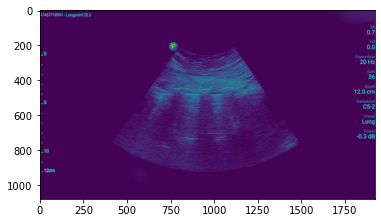

In [60]:
import matplotlib.pyplot as plt

plt.imshow(imgA[50])